Parsing xml tree file...
Generating alpha matrix...
Sampling p's from Dirichlet distribution...
Sampling cell total UMIs from logNormal distribution...
Sampling cells from multinomial distribution...


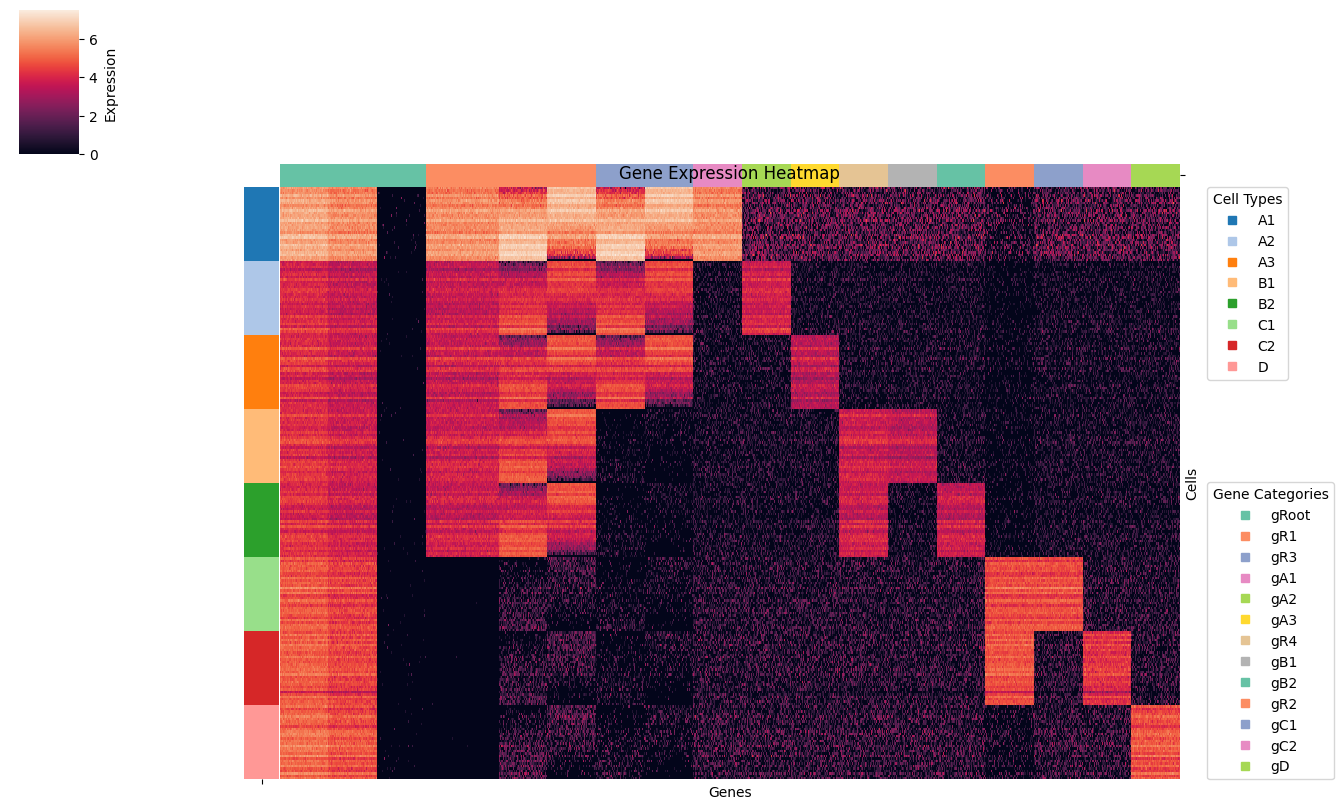

Saving anndata to: ../sim_data/adata/adata_17.h5ad


In [1]:
from hiererchical_simulator import *

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

data_df, adata = get_data_and_visualize(tree_id=17)

In [1]:
from hiererchical_simulator import *

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from numba import njit, prange
from multiprocessing import Pool
from multiprocessing import Process, Manager,cpu_count

@njit(parallel=True, fastmath=True, nopython=True)
def CME_numba(X):

    # _, gene_num = X.shape
    gene_num, _ = X.shape
    min_result = np.zeros((gene_num, gene_num), dtype=np.int64)
    (i_ind, j_ind) = np.triu_indices(gene_num)

    for k in prange(len(i_ind)):
        i = i_ind[k]
        j = j_ind[k]
        min_ary = np.minimum(X[i,:], X[j,:])
        min_result[j,i] = min_result[i,j] = sum(min_ary)      

    return min_result  

def CME(X):

    min_res = CME_numba(X)
    
    sum_x = np.sum(X, axis=1)
    ratio_x = min_res / sum_x[:, None]
    ratio_y = min_res / sum_x[None, :]
    result = 1 - np.maximum(ratio_x, ratio_y)

    return result.T

/home/luting/.local/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [4]:
def dropout(n_genes, adata):
    n_cells = adata.shape[0]

    data_matrix = np.zeros((n_cells, n_genes), dtype=np.float32)

    for gene_idx in range(n_genes):
        expression_counts = np.random.randint(1, 101, size=n_genes)
        cell_indices = [np.random.choice(n_cells, size=x, replace=False) for x in expression_counts]
        expression_values = [np.random.uniform(low=0.1, high=1.0, size=x) for x in expression_counts]
        data_matrix[cell_indices[gene_idx], gene_idx] = expression_values[gene_idx]

    gene_names = [f"gDrop_{i}" for i in range(n_genes)]
    cell_names = adata.obs_names

    # 创建 AnnData 对象
    adata_drop = ad.AnnData(
        X=data_matrix,
        var=pd.DataFrame(index=gene_names),
        obs=pd.DataFrame(index=cell_names)
    )
    merged_adata = ad.concat(
        [adata_drop, adata],
        axis=1,          
        join="outer",    
        merge="unique"   
    )
    return merged_adata


Parsing xml tree file...
Generating alpha matrix...
Sampling p's from Dirichlet distribution...
Sampling cell total UMIs from logNormal distribution...
Sampling cells from multinomial distribution...


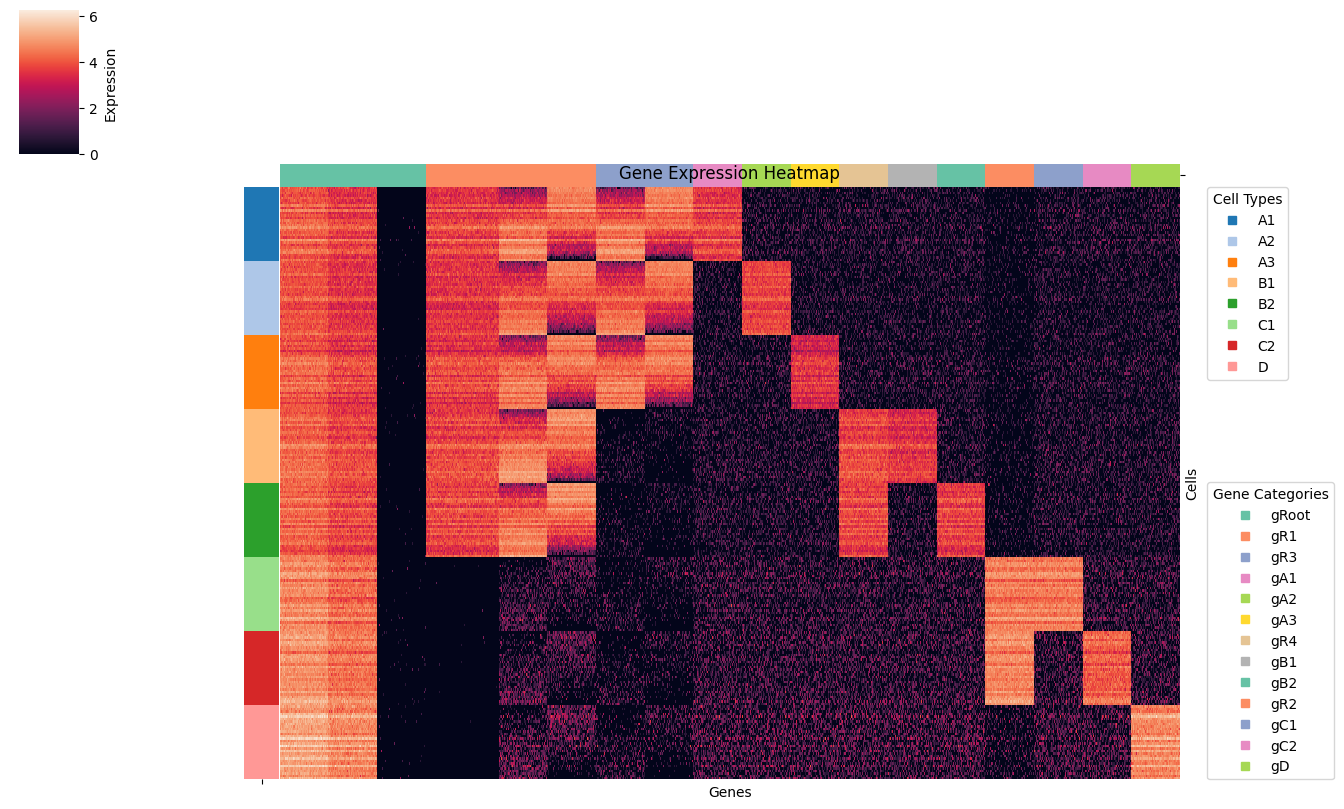

Saving anndata to: ../sim_data/adata/adata_17.h5ad


In [2]:
data_df, adata = get_data_and_visualize(tree_id=17)

In [9]:
adata = dropout(500, adata)

In [10]:
sc.pp.normalize_total(adata)

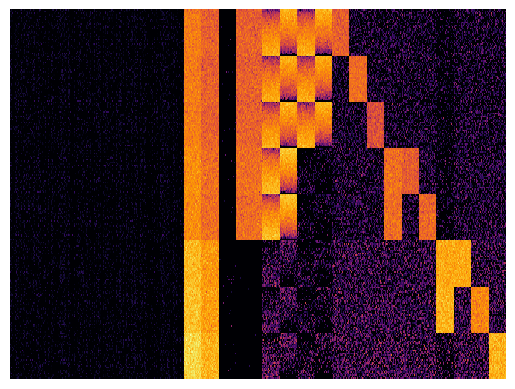

In [11]:
sns.heatmap(
    # np.log(adata_me.X+1),
    np.log(adata.X+1),
    cmap="inferno",
    xticklabels=False, yticklabels=False,
    cbar=False
)


plt.show()


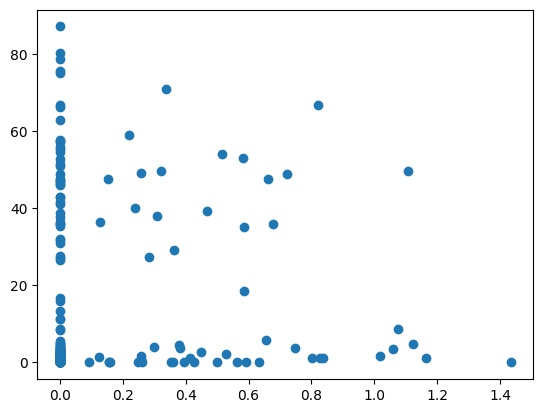

In [12]:
plt.scatter(adata.X[:,0], adata.X[:,1101])

In [13]:
cme_res = CME(adata.X.T)

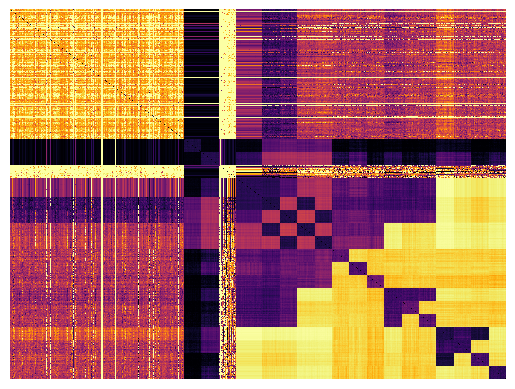

In [14]:
sns.heatmap(
    # np.log(adata_me.X+1),
    cme_res,
    cmap="inferno",
    xticklabels=False, yticklabels=False,
    cbar=False
)


plt.show()


In [15]:
cme_res[0,1]

0.7861491193468928

In [16]:
cme_res[0,501]

0.002029223618833065

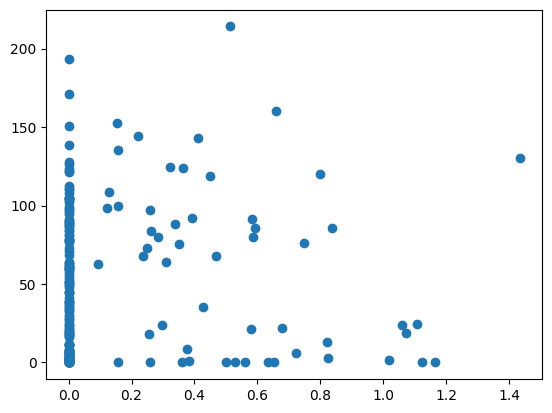

In [17]:
plt.scatter(adata.X[:,0], adata.X[:,801])

In [18]:
adata.write("sim_data/adata/mule_sim.h5ad")

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'sim_data/adata/mule_sim.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)